In [1]:
import glob
import os
from os.path import join
from Bio.Seq import Seq
from Bio import SeqIO
import sys
import os

from Bio.Alphabet import generic_dna

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
data_dir = "/data2/isshamie/mito_lineage/data/processed/200403_A00953_0090_BHC23FDSXY/small_set/"
r2 = join(data_dir ,"A_R2_small.fastq")
r1 = join(data_dir ,"A_R1_small.fastq")

r2

'/data2/isshamie/mito_lineage/data/processed/200403_A00953_0090_BHC23FDSXY/small_set/A_R2_small.fastq'

In [3]:
def process(lines=None):
    ks = ['name', 'sequence', 'optional', 'quality']
    return {k: v for k, v in zip(ks, lines)}


In [4]:
def load_fastq(f_in):
    n = 4
    all_seqs = dict()
    all_records = dict()
    with open(f_in, 'r') as fh:
        lines = []
        for line in fh:
            lines.append(line.rstrip())
            if len(lines) == n:
                record = process(lines)
                all_records[record['name']] = record
                all_seqs[record['name'].split(" ")[0]] = record["sequence"]
                #sys.stderr.write("Record: %s\n" % (str(record)))
                lines = []
    return all_seqs, all_records

In [5]:
r1_all_seqs, r1_all_records = load_fastq(r1)

In [6]:
r2_all_seqs, r2_all_records = load_fastq(r2)
r2_all_seqs_reverse = dict()
for i in r2_all_seqs:
    r2_all_seqs_reverse[i] = str(Seq(r2_all_seqs[i], generic_dna).reverse_complement())

In [7]:
both_r1_r2REV = dict()
for curr1 in r1_all_seqs:
    both_r1_r2REV[curr1]= (r1_all_seqs[curr1], r2_all_seqs_reverse[curr1], r2_all_seqs[curr1])
reads = pd.DataFrame(both_r1_r2REV,index=["R1", "R2 Rev", "R2"]).transpose()

In [8]:
r2_rev_fq = ""
for i in r2_all_records:
    r2_rev_fq =  r2_rev_fq + r2_all_records[i]["name"] + "\n" + r2_all_seqs_reverse[i.split(" ")[0]] + "\n" + r2_all_records[i]["optional"] + "\n" + r2_all_records[i]["quality"] + "\n"
with open(r2.replace('.fastq','reverse.fastq'), 'w') as f:
    f.write(r2_rev_fq)

In [9]:
from Bio import pairwise2 as pw2
from Bio.pairwise2 import format_alignment

## For paired R1 and the reverse complement of R2, run local alignment

In [10]:
scores = dict()
small_frag = list()
small_frag_dict = dict()
for ind, val in reads.iterrows():
    match = 10
    mismatch = -1
    gap = -100
    extend = -50
    
    
    print(val)
    scores[ind] = pw2.align.localms(val["R1"], val["R2 Rev"], 5, -1, -10, -2)
    print("Local Alignment")
    print(format_alignment(*scores[ind][0]))
    
    #IF greater than 30 matching: >300
    if scores[ind][0][2] > match*20:
        small_frag.append(ind)
        small_frag_dict[ind] = (scores[ind][0][3], scores[ind][0][4])
        
print("Fraction of sequences with a score over 20 matches ")
print(len(small_frag)/len(reads))

R1        NGTTCTGCAGTAAGATTCCTATCTAGTATCCTTAATCATTTTGTAC...
R2 Rev    AAAATTTTTTCCTTACCTTTGTTTTTTTTTTTTTTTTTTTTTTTTT...
R2        ACGCAAAGGTAAAAAAAAAAAAAAAAAAAAAAAAAAAGAAAAAAAA...
Name: @A00953:90:HC23FDSXY:3:1101:7600:1000, dtype: object
Local Alignment
 3 TTCTGCAGTAAGATTCCTATCTAGTATCCTTAATCATTTTGTACTCTGCGTTGATACCACTGCTT
   ||.|....|....||..|.|.|..|.||.||..|..||||.|..|.|...||..||||..|||.|
37 TTTTTTTTTTTTTTTTTTTTTTTTTTTCTTTTTTTTTTTTTTTTTTTTTTTTTTTACCTTTGCGT
  Score=127

R1        NCTGATGAGATCTGCTCCGAGGTGATTTTCATATGTACTCTGCGTT...
R2 Rev    CCGACAACTACACTCTTTCCCTACACGACGCTCTTCCGATCTACTG...
R2        AAGCAGTGGTATCAACGCAGAGTACATATGAAAATCACCTCGGAGC...
Name: @A00953:90:HC23FDSXY:3:1101:7672:1000, dtype: object
Local Alignment
 2 CTGATGAGATCTGCTCCGAGGTGATTTTCATATGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
44 CTGATGAGATCTGCTCCGAGGTGATTTTCATATGTACTCTGCGTTGATACCACTGCTT
  Score=290

R1        NCGCCAGGTCAAGCGATATCAAGTGGTTTCTTATATGGGTAGCAAT...
R2 Rev    C

Name: @A00953:90:HC23FDSXY:3:1101:4562:1063, dtype: object
Local Alignment
 1 TGAGAGGGTAGCTGCCAGGGAATAATCTCCCATATTGTAACTGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
35 TGAGAGGGTAGCTGCCAGGGAATAATCTCCCATATTGTAACTGTACTCTGCGTTGATACCACTGCTT
  Score=335

R1        AAGTCTGCAAGGTTCTAGTAATGGGGTTTGTGGGGGTACTCTGCGT...
R2 Rev    CCCCCCCCCCACTCTTTCCCTACACGACGCTCTTCCGATCTAAGTC...
R2        AAGCAGTGGTATCAACGCAGAGTACCCCCACAAACCCCATTACTAG...
Name: @A00953:90:HC23FDSXY:3:1101:17544:1063, dtype: object
Local Alignment
 1 AAGTCTGCAAGGTTCTAGTAATGGGGTTTGTGGGGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
42 AAGTCTGCAAGGTTCTAGTAATGGGGTTTGTGGGGGTACTCTGCGTTGATACCACTGCTT
  Score=300

R1        GCAAACTCACGGCGTTCCATTACCGGGTTTTCCTCTTGTACTCTGC...
R2 Rev    CCCCCACCACTCTTTCCCTACACGACGCTCTTCCGATCTGCAAACT...
R2        AAGCAGTGGTATCAACGCAGAGTACAAGAGGAAAACCCGGTAATGG...
Name: @A00953:90:HC23FDSXY:3:1101:21739:1063, dtype: objec

R1        TCCACACTCTTCCACACAGTACTCTGCGTTGATACCACTGCTTAGA...
R2 Rev    CATGATCCGGCGACCACCGAGATCTACACTCTTTCCCTACACGACG...
R2        AAGCAGTGGTATCAACGCAGAGTACTGTGTGGAAGAGTGTGGAAGA...
Name: @A00953:90:HC23FDSXY:3:1101:29532:1125, dtype: object
Local Alignment
 1 TCCACACTCTTCCACACAGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||
59 TCCACACTCTTCCACACAGTACTCTGCGTTGATACCACTGCTT
  Score=215

R1        TCACGAACACACTTATCCCCACCTTGGGTACTCTGCGTTGATACCA...
R2 Rev    GCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGA...
R2        AAGCAGTGGTATCAACGCAGAGTACCCAAGGTGGGGATAAGTGTGT...
Name: @A00953:90:HC23FDSXY:3:1101:32298:1125, dtype: object
Local Alignment
 1 TCACGAACACACTTATCCCCACCTTGGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||
50 TCACGAACACACTTATCCCCACCTTGGGTACTCTGCGTTGATACCACTGCTT
  Score=260

R1        GGATTACCATCATCCCTGTAGCATTGTTCGTGTACTCTGCGTTGAT...
R2 Rev    CCCCCCACCCACCCACTCTTTCCCTACACGACGCTCTTCCGATCTG...
R2        AAGCAGTGGTATCAACGCAGAGT

Local Alignment
 1 AGCAGCCCTATACTCCCTCTACAGTACTCTGCATTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||
54 AGCAGCCCTATACTCCCTCTACAGTACTCTGCATTGATACCACTGCTT
  Score=240

R1        AGCCTAATCCCACTTGGGCCCGTATTTACCCTATAGGTACTCTGCG...
R2 Rev    CCCCCCACCACTCTTTCCCTACACGACGCTCTTCCGATCTAGCCTA...
R2        AAGCAGTGGTATCAACGCAGAGTACCTATAGGGTAAATACGGGCCC...
Name: @A00953:90:HC23FDSXY:3:1101:8585:1235, dtype: object
Local Alignment
 1 AGCCTAATCCCACTTGGGCCCGTATTTACCCTATAGGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
41 AGCCTAATCCCACTTGGGCCCGTATTTACCCTATAGGTACTCTGCGTTGATACCACTGCTT
  Score=305

R1        GCGCCAACACCTCTTTACAGTGAGTACTCTGCGTTGATACCACTGC...
R2 Rev    CCCCCCCCCCCCCCCCACCAACACTCTTTCCCTACACGACGCTCTT...
R2        AAGCAGTGGTATCAACGCAGAGTACTCACTGTAAAGAGGTGTTGGC...
Name: @A00953:90:HC23FDSXY:3:1101:9815:1235, dtype: object
Local Alignment
 1 GCGCCAACACCTCTTTACAGTGAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||

Local Alignment
 1 TGGGAAGAGGATGGTCACACGATTAACCCAAGTGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
44 TGGGAAGAGGATGGTCACACGATTAACCCAAGTGTACTCTGCGTTGATACCACTGCTT
  Score=290

R1        GGCGACTTCGCCATCCCTGTAGCATTGTTCGTGTACTCTGCGTTGA...
R2 Rev    CCCCCCCCACCCCACTCTTTCCCTACACGACGCTCTTCCGATCTGG...
R2        AAGCAGTGGTATCAACGCAGAGTACACGAACAATGCTACAGGGATG...
Name: @A00953:90:HC23FDSXY:3:1101:10131:1376, dtype: object
Local Alignment
 1 GGCGACTTCGCCATCCCTGTAGCATTGTTCGTGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||
45 GGCGACTTCGCCATCCCTGTAGCATTGTTCGTGTACTCTGCGTTGATACCACTGCTT
  Score=285

R1        CGCGTTTTCCACAACCTTAGCCAAACCATTGTACTCTGCGTTGATA...
R2 Rev    CCCCCCCCCACACACACTCTTTCCCTACACGACGCTCTTCCGATCT...
R2        AAGCAGTGGTATCAACGCAGAGTACAATGGTTTGGCTAAGGTTGTG...
Name: @A00953:90:HC23FDSXY:3:1101:14271:1376, dtype: object
Local Alignment
 1 CGCGTTTTCCACAACCTTAGCCAAACCATTGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||

Local Alignment
 1 CTGATAGAGCCTATGTTGTTCGCAAATACTCAAATGGGCCTGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
36 CTGATAGAGCCTATGTTGTTCGCAAATACTCAAATGGGCCTGTACTCTGCGTTGATACCACTGCTT
  Score=330

R1        TTAGGACTCATGCATGTCGCACACACTTATCCCCACCTTGGGTACT...
R2 Rev    CACCACTCTTTCCCTACACGACGCTCTTCCGATCTTTAGGACTCAT...
R2        AAGCAGTGGTATCAACGCAGAGTACCCAAGGTGGGGATAAGTGTGT...
Name: @A00953:90:HC23FDSXY:3:1101:6117:1501, dtype: object
Local Alignment
 1 TTAGGACTCATGCATGTCGCACACACTTATCCCCACCTTGGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
36 TTAGGACTCATGCATGTCGCACACACTTATCCCCACCTTGGGTACTCTGCGTTGATACCACTGCTT
  Score=330

R1        CCCAATCCACAGGTTTGTTCGATTCCTTCCTTTTTTGGTACTCTGC...
R2 Rev    CCCCACCCCCTCTTTCCCTACACGACGCTCTTCCGATCTCCCAATC...
R2        AAGCAGTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAAC...
Name: @A00953:90:HC23FDSXY:3:1101:6641:1501, dtype: object
Local Alignment
 1 CCCAATCCACAGGTTTGTTCGATTC

Local Alignment
 1 AACTTTCAGGTGCACACCACTTTCAATTCCTCTTCTTAACAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
36 AACTTTCAGGTGCACACCACTTTCAATTCCTCTTCTTAACAGTACTCTGCGTTGATACCACTGCTT
  Score=330

R1        CAGCTGGAGTCATCCAAACCCCCTGAAGCTTCAGTACTCTGCGTTG...
R2 Rev    CCCGTGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTCAG...
R2        AAGCAGTGGTATCAACGCAGAGTACTGAAGCTTCAGGGGGTTTGGA...
Name: @A00953:90:HC23FDSXY:3:1101:22525:1611, dtype: object
Local Alignment
 1 CAGCTGGAGTCATCCAAACCCCCTGAAGCTTCAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
44 CAGCTGGAGTCATCCAAACCCCCTGAAGCTTCAGTACTCTGCGTTGATACCACTGCTT
  Score=290

R1        AACGTAATCCAAGCCTCACCCCACGTACTCTGCGTTGATACCACTG...
R2 Rev    CCGGCGACCACCGAGACCTACACTCTTTCCCTACACGACGCTCTTC...
R2        AAGCAGTGGTATCAACGCAGAGTACGTGGGGTGAGGCTTGGATTAC...
Name: @A00953:90:HC23FDSXY:3:1101:23918:1611, dtype: object
Local Alignment
 1 AACGTAATCCAAGCCTCACCCCACGTACTCTGCGTTGATACCACTGC

Local Alignment
 1 AAAGTAGGTGTTTGGCCCGTATTTACCCTATAGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
44 AAAGTAGGTGTTTGGCCCGTATTTACCCTATAGGTACTCTGCGTTGATACCACTGCTT
  Score=290

R1        GTCACAAAGTGCTGCTCCGAGGTGATTTTCATATGTACTCTGCGTT...
R2 Rev    CCGCCACCCACACTCTTTCCCTACACGACGCTCTTCCGATCTGTCA...
R2        AAGCAGTGGTATCAACGCAGAGTACATATGAAAATCACCTCGGAGC...
Name: @A00953:90:HC23FDSXY:3:1101:14950:1705, dtype: object
Local Alignment
 1 GTCACAAAGTGCTGCTCCGAGGTGATTTTCATATGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
43 GTCACAAAGTGCTGCTCCGAGGTGATTTTCATATGTACTCTGCGTTGATACCACTGCTT
  Score=295

R1        TTAGGCAAGAGCTGGTCTTCGATTCCTTCCTTTTTTGGTACTCTGC...
R2 Rev    GCCCCCACACTCTTTCCCTACACGACGCTCTTCCGATCTTTAGGCA...
R2        AAGCAGTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAAG...
Name: @A00953:90:HC23FDSXY:3:1101:16414:1705, dtype: object
Local Alignment
 1 TTAGGCAAGAGCTGGTCTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
   ||

Local Alignment
 1 CCGGGATAGAGTACATCCCTGTAGCATTGTTCGTGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
43 CCGGGATAGAGTACATCCCTGTAGCATTGTTCGTGTACTCTGCGTTGATACCACTGCTT
  Score=295

R1        TGCTACCGTGTAAGTATTTCGATTCCTTCCTTTTTTGGTACTCTGC...
R2 Rev    CCCCCAACACTCTTTCCCTACACGACGCTCTTCCGATCTTGCTACC...
R2        AAGCAGTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAAA...
Name: @A00953:90:HC23FDSXY:3:1101:9362:1799, dtype: object
Local Alignment
 1 TGCTACCGTGTAAGTATTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
40 TGCTACCGTGTAAGTATTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
  Score=310

R1        GCGCGATTCACAGTACATCGAGACTCTTTCTTAGTAATGGGGTTTG...
R2 Rev    TTCCCCTACACGACGCTCTTCCGATCTGCGCGATTCACAGTACATC...
R2        GCAGTGGTATCAACGCAGAGTACCCCCACAAACCCCATTACTAAGA...
Name: @A00953:90:HC23FDSXY:3:1101:12888:1799, dtype: object
Local Alignment
 1 GCGCGATTCACAGTACATCGAGACTCTTTCTTAGTAATGGGGTTTGTGGGGGTACTC

 1 GCTGGGTTCTTAACCTCCGAGCAGTACATGCGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||
46 GCTGGGTTCTTAACCTCCGAGCAGTACATGCGTACTCTGCGTTGATACCACTGCTT
  Score=280

R1        GGGACCTTCGAACGGAATAGCTTATCTTTCTTTTCACCGTAGGGTA...
R2 Rev    CCACACTTTCCCTACACGACGCTCTTCCGATCTGGGACCTTCGAAC...
R2        AAGCAGTGGTATCAACGCAGAGTACCCTACGGTGAAAAGAAAGATA...
Name: @A00953:90:HC23FDSXY:3:1101:10755:1955, dtype: object
Local Alignment
 1 GGGACCTTCGAACGGAATAGCTTATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
34 GGGACCTTCGAACGGAATAGCTTATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
  Score=340

R1        TAGTTGGGTGGACGACAACGATGGTTTTTCATATCATTGGTACTCT...
R2 Rev    TTATTTACATTCTTTCCCTACACGAGGCTTTTCCTTTCTTTGTTGG...
R2        GCACTGGTATAAAACCAGAGTAACAAAGAAAATAAAAAACAACCTT...
Name: @A00953:90:HC23FDSXY:3:1101:19795:1955, dtype: object
Local Alignment
 1 TAGTTGGGTGGACGACAACGATGGTTTTTCATATCATTGGTACTCTGCGTTGATACCACTGC


Local Alignment
 1 GGAAAGCAGCCGGTAAATTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
40 GGAAAGCAGCCGGTAAATTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
  Score=310

R1        TGCTACCGTTGTGCCCCTACTCCTCCTAGACGTACTCTGCGTTGAT...
R2 Rev    CCCCCCCCACCCACACTCTTTCCCTACACGACGCTCTTCCGATCTT...
R2        AAGCAGTGGTATCAACGCAGAGTACGTCTAGGAGGAGTAGGGGCAC...
Name: @A00953:90:HC23FDSXY:3:1101:15067:2065, dtype: object
Local Alignment
 1 TGCTACCGTTGTGCCCCTACTCCTCCTAGACGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||
46 TGCTACCGTTGTGCCCCTACTCCTCCTAGACGTACTCTGCGTTGATACCACTGCTT
  Score=280

R1        TAAGAGACATTACCGGGTTTTCCTCTTGTACTCTGCGTTGATACCA...
R2 Rev    GCCCCCCCCCCGCCACCCCCCCTCTTTCCCTACACGACGCTCTTCC...
R2        GCAGTGGTATCAACGCAGAGTACAAGAGGAAAACCCGGTAATGTCT...
Name: @A00953:90:HC23FDSXY:3:1101:24234:2065, dtype: object
Local Alignment
 1 TAAGAGACATTACCGGGTTTTCCTCTTGTACTCTGCGTTGATACCACTGC
   |||||||||||

Name: @A00953:90:HC23FDSXY:3:1101:8666:2159, dtype: object
Local Alignment
 1 ACTTTCATCAACTCTTTCAATTCCTCTTCTTAACAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
42 ACTTTCATCAACTCTTTCAATTCCTCTTCTTAACAGTACTCTGCGTTGATACCACTGCTT
  Score=300

R1        GCAAACTCAACGATGGTTTTTCATATCATTGGTACTCTGCGTTGAT...
R2 Rev    CCCCCCTCACACACACTCTTTCCCTACACGACGCTCTTCCGATCTG...
R2        AAGCAGTGGTATCAACGCAGAGTACCAATGATATGAAAAACCATCG...
Name: @A00953:90:HC23FDSXY:3:1101:9588:2159, dtype: object
Local Alignment
 1 GCAAACTCAACGATGGTTTTTCATATCATTGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||
46 GCAAACTCAACGATGGTTTTTCATATCATTGGTACTCTGCGTTGATACCACTGCTT
  Score=280

R1        TTCGGTCGTCCATCCTCAATACTCATCATTAATAAGTACTCTGCGT...
R2 Rev    CCCCACCAACACTCTTTCCCTACACGACGCTCTTCCGATCTTTCGG...
R2        AAGCAGTGGTATCAACGCAGAGTACTTATTAATGATGAGTATTGAG...
Name: @A00953:90:HC23FDSXY:3:1101:10059:2159, dtype: object
Local Alignment
 1 TTCGGTCGTCCAT

Name: @A00953:90:HC23FDSXY:3:1101:26603:2284, dtype: object
Local Alignment
 1 CCACCTATCTTTCCTCACCACCTCTTGCTCAGGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||
45 CCACCTATCTTTCCTCACCACCTCTTGCTCAGGTACTCTGCGTTGATACCACTGCTT
  Score=285

R1        GACTGCGCACGAGAGTATATTCGATTCCTTCCTTTTTTGGTACTCT...
R2 Rev    TCCAACAGCCTTTCCCTAGACGACGCTCTTCCGATCTGACTGCGCA...
R2        AAGCAGTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAAT...
Name: @A00953:90:HC23FDSXY:3:1101:28176:2284, dtype: object
Local Alignment
 1 GACTGCGCACGAGAGTATATTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
38 GACTGCGCACGAGAGTATATTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
  Score=320

R1        CACTCCACATTTGCTTTCTGATTCGATTCCTTCCTTTTTTGGTACT...
R2 Rev    CCCCCCACCACCCTTTCCCTACACGACGCTCTTCCGATCTCACTCC...
R2        GTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAATCAGAA...
Name: @A00953:90:HC23FDSXY:3:1101:10972:2300, dtype: object
Local Alignment

Local Alignment
 1 CCGGTAGAGGATATACTGTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
39 CCGGTAGAGGATATACTGTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
  Score=315

R1        GAATAAGAGTCGGCCAATATCTTTCTTTTCACCGTAGGGTACTCTG...
R2 Rev    CACCCCCACTCTTTCCCTACACGACGCTCTTCCGATCTGAATAAGA...
R2        AAGCAGTGGTATCAACGCAGAGTACCCTACGGTGAAAAGAAAGATA...
Name: @A00953:90:HC23FDSXY:3:1101:23538:2456, dtype: object
Local Alignment
 1 GAATAAGAGTCGGCCAATATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||.||||||||||||||||||||||||||||||||||||||||||||||||||||
39 GAATAAGAGTAGGCCAATATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
  Score=309

R1        TCAGCAACAGGGTTAGGCCTCTTTTTACCAGTACTCTGCGTTGATA...
R2 Rev    CCCCCCCACAACCCCACAGTTTCCCTACACGACGCTCTTCCGATCT...
R2        AAGCAGTGGTATCAACGCAGAGTACTGGTAAAAAGAGGCCTAACCC...
Name: @A00953:90:HC23FDSXY:3:1101:26485:2456, dtype: object
Local Alignment
 1 TCAGCAACAGGGTTAGGCCTCTTTTTACCAGTACTCTGCGT

Local Alignment
 1 AACTCCCAACTAAGCATACCACAATAAATCATCAAATATACAACTCATACATAAAACAACATCTT
   |||||||..|..||..|.|..||.||.....||||.|.|...||||.....|.|.||.||..|||
37 AACTCCCTCCGTAGGCTCCGTCATTATTGGCTCAACTTTCGTACTCTGCGTTGATACCACTGCTT
  Score=145

R1        GTCGTAACAACGATGGTTTTCATATCATTGGTACTCTGCGTTGATA...
R2 Rev    CCCCCCCACACCCCCACTCTTTCCCTACACGACGCTCTTCCGATCT...
R2        AAGCAGTGGTATCAACGCAGAGTACCAATGATATGAAAACCATCGT...
Name: @A00953:90:HC23FDSXY:3:1101:11216:2534, dtype: object
Local Alignment
 1 GTCGTAACAACGATGGTTTTCATATCATTGGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||
47 GTCGTAACAACGATGGTTTTCATATCATTGGTACTCTGCGTTGATACCACTGCTT
  Score=275

R1        ATTACTCCAATACGCTAACAACATGGCTTTCTCAGTACTCTGCGTT...
R2 Rev    CCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTATTA...
R2        AAGCAGTGGTATCAACGCAGAGTACTGAGAAAGCCATGTTGTTAGC...
Name: @A00953:90:HC23FDSXY:3:1101:12970:2534, dtype: object
Local Alignment
 1 ATTACTCCAATACGCTAACAACATGGCTTTCTCAGTACTCTGCGTTGATACCACTGCTT

Local Alignment
 1 AGGCCACCCTACTAAACCCCATTGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||
54 AGGCCACCCTACTAAACCCCATTGTACTCTGCGTTGATACCACTGCTT
  Score=240

R1        GTTCGGTCATCATTCTTCGATTCCTTCCTTTTTTGGTACTCTGCGT...
R2 Rev    CTATATATACACTCTTTCCCTACACGACGCTCTTCCGATCTGTTCG...
R2        AAGCAGTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAAG...
Name: @A00953:90:HC23FDSXY:3:1101:3613:2675, dtype: object
Local Alignment
 1 GTTCGGTCATCATTCTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
42 GTTCGGTCATCATTCTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
  Score=300

R1        CTCTACGTCCTCATTATCGTTATACCCTTCCCGTACTAGTACTCTG...
R2 Rev    ACACCCCCACTCTTTCCCTACACGACGCTCTTCCGATCTCTCTACG...
R2        AAGCAGTGTATCAACGCAGAGTACTAGTACGGGAAGGGTATAACGA...
Name: @A00953:90:HC23FDSXY:3:1101:19036:2675, dtype: object
Local Alignment
 1 CTCTACGTCCTCATTATCGTTATACCCTTCCCGTACTAGTACTCTGCGTTGATACACTGCTT
   ||||||||||||||||||||||||||||||

Local Alignment
 1 CTCGTACGTCACCTAATTGGAAGCGCCACGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||
48 CTCGTACGTCACCTAATTGGAAGCGCCACGTACTCTGCGTTGATACCACTGCTT
  Score=270

R1        GTCATTTTCGCGATCGTCTGATTCGATTCCTTCCTTTTTTGGTACT...
R2 Rev    GCCCCCTCTTTCCCTCCCCGACGCTCTTCCGTTCTGTCATTTTCGC...
R2        AAGCAGTGGTATCAACGCAGAGTACCAAACAAGGAAGGAATCGAAT...
Name: @A00953:90:HC23FDSXY:3:1101:30680:2769, dtype: object
Local Alignment
 1 GTCATTTTCGCGATCGTCTGATTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||
36 GTCATTTTCGCGATCGTCTGATTCGATTCCTTCCTTGTTTGGTACTCTGCGTTGATACCACTGCTT
  Score=324

R1        CGAATGTGTCTTGATGCAGCCCTATACTCCCTCTACAGTACTCTGC...
R2 Rev    CCCCCACCCCTCTTTCCCTACACGACGCTCTTCCGATCTCGAATGT...
R2        AAGCAGTGGTATCAACGCAGAGTACTGTAGAGGGAGTATAGGGCTG...
Name: @A00953:90:HC23FDSXY:3:1101:6967:2785, dtype: object
Local Alignment
 1 CGAATGTGTCTTGATGCAGCCCTATACTCCCTCTACAGTACTCTGCGTTGATACCACTGC

Local Alignment
 1 CGATGTATCTGCTGCTGAGCCTTCGATTCTCATAGTCCTAGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
36 CGATGTATCTGCTGCTGAGCCTTCGATTCTCATAGTCCTAGGTACTCTGCGTTGATACCACTGCTT
  Score=330

R1        AACTTTCAGGTTACCTTAAACCCCCTTATTTCTAGTACTCTGCGTT...
R2 Rev    CCCCCAACCCCACTCTTTCCCTACACGACGCTCTTCCGATCTAACT...
R2        AAGCAGTGGTATCAACGCAGAGTACTAGAAATAAGGGGGTTTAAGG...
Name: @A00953:90:HC23FDSXY:3:1101:24994:2879, dtype: object
Local Alignment
 1 AACTTTCAGGTTACCTTAAACCCCCTTATTTCTAGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
43 AACTTTCAGGTTACCTTAAACCCCCTTATTTCTAGTACTCTGCGTTGATACCACTGCTT
  Score=295

R1        TCTCTAAAGTTGAGTATGCGGTTCGATTCCTTCCTTTTTTGGTACT...
R2 Rev    ACCCCCCCCCTCTTTCCCTACACGACGCTCTTCCGATCTTCTCTAA...
R2        AGTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAACCGCA...
Name: @A00953:90:HC23FDSXY:3:1101:28067:2879, dtype: object
Local Alignment
 1 TCTCTAAAGTTGAGTATGCGGTTCGATTCCTTCCTTTTTTGGTA

Local Alignment
 1 CGATCGGGTGACTACTAACAACATGGCTTTCTCAGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
43 CGATCGGGTGACTACTAACAACATGGCTTTCTCAGTACTCTGCGTTGATACCACTGCTT
  Score=295

R1        GAAATGATCTAACTGGTTCGATTCCTTCCTTTTTTGGTACTCTGCG...
R2 Rev    CCCACCCCCACTCTTTCCCTACACGACGCTCTTCCGATCTGAAATG...
R2        AAGCAGTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAAC...
Name: @A00953:90:HC23FDSXY:3:1101:15826:2973, dtype: object
Local Alignment
 1 GAAATGATCTAACTGGTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
41 GAAATGATCTAACTGGTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
  Score=305

R1        GAGGTGATCTTCCTTCATCCCTGTAGCATTGTTCGTGTACTCTGCG...
R2 Rev    GAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTGAGGTG...
R2        AAGCAGTGGTATCAACGCAGAGTACACGAACAATGCTACAGGGATG...
Name: @A00953:90:HC23FDSXY:3:1101:17454:2973, dtype: object
Local Alignment
 1 GAGGTGATCTTCCTTCATCCCTGTAGCATTGTTCGTGTACTCTGCGTTGATACCACTGC

Local Alignment
3 CACAAAGTGCATCCC------TGTGCATTGTTCGTG----TACTCTGCGTTGATACCACTGCTTGATCGGAA-GAGCACACGTCTGAACTCC
  |.|.....||.||||      |||||..||||..||    |..|.||..||..|.....||.||..|.||.. |.||.|.|..|....|.||
7 CCCCCTTCGCCTCCCCCGCTGTGTGCTCTGTTGTTGGTTTTTTTTTGTTTTTGTTTGTTTGTTTTTTTGGTGTGGGCGCCCCCCCCCCCCCC
  Score=125

R1        CTCTGGTGTTGAACTCATACCCTACTCCTAATCACATAAGTACTCT...
R2 Rev    CCCCCCACTCTTTCCCTACACGACGCTCTTCCGATCTCTCTGGTGT...
R2        AAGCAGTGGTATCAACGCAGAGTACTTATGTGATTAGGAGTAGGGT...
Name: @A00953:90:HC23FDSXY:3:1101:24975:3067, dtype: object
Local Alignment
 1 CTCTGGTGTTGAACTCATACCCTACTCCTAATCACATAAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
38 CTCTGGTGTTGAACTCATACCCTACTCCTAATCACATAAGTACTCTGCGTTGATACCACTGCTT
  Score=320

R1        ATGTGTGCATCTCGATCCCTACTCCTAATCACATAAGTACTCTGCG...
R2 Rev    GCCCCCCCCCCTCTTGCCCTCCACGACGCTCTTCCGATCTATGTGT...
R2        AAGCAGTGGTATCAACGCAGAGTACTTATGTGATTAGGAGTAGGGA...
Name: @A00953:90:HC23FDSXY:3:1101

Name: @A00953:90:HC23FDSXY:3:1101:21820:3208, dtype: object
Local Alignment
 1 TGGGAAGAGGTCGGATCTTCGCAAAATACTCAAATGGGCCTGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
36 TGGGAAGAGGTCGGATCTTCGCAAAATACTCAAATGGGCCTGTACTCTGCGTTGATACCACTGCTT
  Score=330

R1        CTGCTGTGTCAGAATATCTTTCCATCTTTCTTTTCACCGTAGGGTA...
R2 Rev    TCCCCTCCCTCCCCTCTGGCCCTCTCTTTTGTTCTCTTTTTTTTTC...
R2        GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGGCGGGAGGCGGG...
Name: @A00953:90:HC23FDSXY:3:1101:22128:3208, dtype: object
Local Alignment
1 CTGCTGTGTCAGAATATCTTTCCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTTGATCGGAAGAGCACACGTCTGAACTCC
  ||.|..|.|.....|.|||||...|||.|.||||...|.|....|.|.|.||.|.....|..|.....|.......|.|.|..|....|.||
9 CTCCCCTCTGGCCCTCTCTTTTGTTCTCTTTTTTTTTCTTCCCTTCCCCCGCCTCCCGCCGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC
  Score=130

R1        TGCCCTATCAGAGACGCACCTGCACGACAACACATAAGTACTCTGC...
R2 Rev    AGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTTGCCCTA...
R2        AAGCAGTGGTATCAACG

R1        ATCATGGCACCGCCTGCCCAGTGACAGTACTCTGCGTTGATACCAC...
R2 Rev    CCCCCCCCCCCCCACCCACACTCTTTCCCTACACGACGCTCTTCCG...
R2        AAGCAGTGGTATCAACGCAGAGTACTGTCACTGGGCAGGCGGTGCC...
Name: @A00953:90:HC23FDSXY:3:1101:10538:3302, dtype: object
Local Alignment
 1 ATCATGGCACCGCCTGCCCAGTGACAGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||
51 ATCATGGCACCGCCTGCCCAGTGACAGTACTCTGCGTTGATACCACTGCTT
  Score=255

R1        CCTTCGAAGCAGCTCCGAGGTGATTTTCATATGTACTCTGCGTTGA...
R2 Rev    CCCCCCCACCACCCCACTTTCCCTACACGACGCTCTTCCGATCTCC...
R2        AAGCAGTGGTATCAACGCAGAGTACATATGAAAATCACCTCGGAGC...
Name: @A00953:90:HC23FDSXY:3:1101:16902:3302, dtype: object
Local Alignment
 1 CCTTCGAAGCAGCTCCGAGGTGATTTTCATATGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||
45 CCTTCGAAGCAGCTCCGAGGTGATTTTCATATGTACTCTGCGTTGATACCACTGCTT
  Score=285

R1        AACTGGTGTACCGCTGTTTCGCGATCTTTCTTTTCACCGTAGGGTA...
R2 Rev    ACACTCTTTCCCTACACGACGCTCTTCCGATCTAACTGGTGTAC

Local Alignment
 1 TCTACCTACGCCTAATCTGTACTCTGCGTTGATACCACTGC
   |||||||||||||||||||||||||||||||||||||||||
61 TCTACCTACGCCTAATCTGTACTCTGCGTTGATACCACTGC
  Score=205

R1        AGTCTTTAGCGGCTTCTTAAACCCCCTTATTTCTAGTACTCTGCGT...
R2 Rev    CCCCCCCCACACTCTTTCCCTACACGACGCTCTTCCGATCTAGTCT...
R2        AAGCAGTGGTATCAACGCAGAGTACTAGAAATAAGGGGGTTTAAGA...
Name: @A00953:90:HC23FDSXY:3:1101:16577:3458, dtype: object
Local Alignment
 1 AGTCTTTAGCGGCTTCTTAAACCCCCTTATTTCTAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
42 AGTCTTTAGCGGCTTCTTAAACCCCCTTATTTCTAGTACTCTGCGTTGATACCACTGCTT
  Score=300

R1        GCACTCTTCCCCCTAGCCACTTGTACTCTGCGTTGATACCACTGCT...
R2 Rev    CCCCCCCCACCCCCCCGCTAACCACTCTTTCCCTACACGACGCTCT...
R2        AAGCAGTGGTATCAACGCAGAGTACAAGTGGCTAGGGGGAAGAGTG...
Name: @A00953:90:HC23FDSXY:3:1101:20121:3458, dtype: object
Local Alignment
 1 GCACTCTTCCCCCTAGCCACTTGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||
55 GCACTCTTCCCCCT

Local Alignment
 1 TCATTTGGTTCAACCACTCACCCACGCCTTCTTCAAGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
41 TCATTTGGTTCAACCACTCACCCACGCCTTCTTCAAGTACTCTGCGTTGATACCACTGCTT
  Score=305

R1        CGACCTTGTCACCTAATTGGAAGCGCCACGTACTCTGCGTTGATAC...
R2 Rev    CCCCCCCCACCACACCACTCTTTCCCTACACGACGCTCTTCCGATC...
R2        AAGCAGTGGTATCAACGCAGAGTACGTGGCGCTTCCAATTAGGTGA...
Name: @A00953:90:HC23FDSXY:3:1101:7021:3630, dtype: object
Local Alignment
 1 CGACCTTGTCACCTAATTGGAAGCGCCACGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||
48 CGACCTTGTCACCTAATTGGAAGCGCCACGTACTCTGCGTTGATACCACTGCTT
  Score=270

R1        GATCATTCTATTTCCCCCGTACTCTGCGTTGATACCACTGCTTAGA...
R2 Rev    AACCCCCCCCCCCCCCCCCACCAACCCACTCTTTCCCTACACGACG...
R2        AAGCAGTGGTATCAACGCAGAGTACGGGGGAAATAGAATGATCAGA...
Name: @A00953:90:HC23FDSXY:3:1101:8305:3630, dtype: object
Local Alignment
 1 GATCATTCTATTTCCCCCGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||

Local Alignment
 1 GATGCTAAGGGTGTTGACCACGCAAATTTCTTATATGGGCCTGTACTCTGCGTTGATACCACTGCT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
36 GATGCTAAGGGTGTTGACCACGCAAATTTCTTATATGGGCCTGTACTCTGCGTTGATACCACTGCT
  Score=330

R1        GGACAGATCATGGTCATCCGTGCCCCTACTCCTCCTAGACGTACTC...
R2 Rev    CCCCCCCCCCCCCCCCCCCCGTCCTCCCTGTCCCCCGCTCTGCCCC...
R2        GGGGGGGGGGGGGGGGGGGGGGGGCGGGGGGGGGGGGGTGGGGGGG...
Name: @A00953:90:HC23FDSXY:3:1101:30897:3740, dtype: object
Local Alignment
15 CATCCGTGCCCCTACTCCTCCTAGACGTACTCTGCGTTGATACCACT-GCTTGATCGGAAGAGCACACGTCTGAACTCCAGTCACC
   |..||...||||..|.|.||||....||.|.|.||..||...||.|. ||.....|...|...|.|.|..|....|.||...|.||
 4 CCCCCCCCCCCCCCCCCGTCCTCCCTGTCCCCCGCTCTGCCCCCGCCCGCCCCCCCCCCACCCCCCCCCCCCCGCCCCCCCCCCCC
  Score=133

R1        TGCCAAAAGCTGCCCAGGACCCAAACATTAATCAGTTGTACTCTGC...
R2 Rev    AGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTTGCCAAA...
R2        AAGCAGTGGTATCAACGCAGAGTACAACTGATTAATGTTTGGGTCC...
Name: @A00953:90:HC23FDSXY:3:1101:31114:37

Local Alignment
 1 CACCTTGTCACCCGAGCACTCACATCTTTCTTT
   |||||||||||||||||||||||||||||||||
69 CACCTTGTCACCCGAGCACTCACATCTTTCTTT
  Score=165

R1        CTGTTTAAGGTTACCTCCATCTTTCTTTTCACCGTAGGGTACTCTG...
R2 Rev    GATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTCTGTTTAA...
R2        AAGCAGTGGTATCAACGCAGAGTACCCTACGGTGAAAAGAAAGATG...
Name: @A00953:90:HC23FDSXY:3:1101:6090:3865, dtype: object
Local Alignment
 1 CTGTTTAAGGTTACCTCCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
39 CTGTTTAAGGTTACCTCCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
  Score=315

R1        TGAGAGGCAGGCGATATGGTTCGATTCCTTCCTTTTTTGGTACTCT...
R2 Rev    CCCAACACTCTTTCCCTACACGACGCTCTTCCGATCTTGAGAGGCA...
R2        AAGCAGTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAAC...
Name: @A00953:90:HC23FDSXY:3:1101:17029:3865, dtype: object
Local Alignment
 1 TGAGAGGCAGGCGATATGGTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Name: @A00953:90:HC23FDSXY:3:1101:4698:4053, dtype: object
Local Alignment
 1 ACTGCTCTCAATCTCTCATTACCGGGTTTTCCTCTTGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
41 ACTGCTCTCAATCTCTCATTACCGGGTTTTCCTCTTGTACTCTGCGTTGATACCACTGCTT
  Score=305

R1        AGCGTATAGCCCTATACTCCCTCTACAGTACTCTGCGTTGATACCA...
R2 Rev    GCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGA...
R2        AAGCAGTGGTATCAACGCAGAGTACTGTAGAGGGAGTATAGGGCTA...
Name: @A00953:90:HC23FDSXY:3:1101:6668:4053, dtype: object
Local Alignment
 1 AGCGTATAGCCCTATACTCCCTCTACAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||
50 AGCGTATAGCCCTATACTCCCTCTACAGTACTCTGCGTTGATACCACTGCTT
  Score=260

R1        ACGGAGAAGGGTTCCCCTCACCACCTCTTGCTCAGGTACTCTGCGT...
R2 Rev    CCCCCCCCCCCCTCTTCCCCTACACGACGCTCTTCCGATCTACGGA...
R2        AAGCAGTGGTATCAACGCAGAGTACCTGAGCAAGAGGTGGTGAGGG...
Name: @A00953:90:HC23FDSXY:3:1101:10845:4053, dtype: object
Local Alignment
 1 ACGGAGAAGGGTTCCCCTCACC

Local Alignment
 1 GTCGGGTGTCCCTACTCCTAATCACATAAGTACTCTGCGTTGATACCACTGCTTGCAGTCCTTAGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
13 GTCGGGTGTCCCTACTCCTAATCACATAAGTACTCTGCGTTGATACCACTGCTTGCAGTCCTTAGTACTCTGCGTTGATACCACTGCTT
  Score=445

R1        TTGACTTAGTTATCGCGCTTGGCCCGTATTTACCCTATAGGTACTC...
R2 Rev    CCCCCACTCTTTCCCTACACGACGCTCTTCCGATCTTTGACTTAGT...
R2        AAGCAGTGGTATCAACGCAGAGTACCTATAGGGTAAATACGGGCCA...
Name: @A00953:90:HC23FDSXY:3:1101:25889:4147, dtype: object
Local Alignment
 1 TTGACTTAGTTATCGCGCTTGGCCCGTATTTACCCTATAGGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
37 TTGACTTAGTTATCGCGCTTGGCCCGTATTTACCCTATAGGTACTCTGCGTTGATACCACTGCTT
  Score=325

R1        TTTATGCAGTTATCGCTCCAAAACCTTTTTCCAAGGACAGTACTCT...
R2 Rev    CCCCCCACTCTTTCCCTACACGACGCTCCTCCGATCTTTTATGCAG...
R2        AAGCAGTGGTATCAACGCAGAGTACTGTCCTTGGAAAAAGGTTTTG...
Name: @A00953:90:HC23FDSXY:3:1101:29

Local Alignment
 1 TTGTAGGAGGGATGGGCGCACTAATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
34 TTGTAGGAGGGATGGGCGCACTAATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
  Score=340

R1        AACTGGTTCTACCCTACTCCTAATCACATAAGTACTCTGCGTTGAT...
R2 Rev    CCCCCCCCACCCACACTCTTTCCCTACACGACGCTCTTCCGATCTA...
R2        AAGCAGTGGTATCAACGCAGAGTACTTATGTGATTAGGAGTAGGGT...
Name: @A00953:90:HC23FDSXY:3:1101:9245:4319, dtype: object
Local Alignment
 1 AACTGGTTCTACCCTACTCCTAATCACATAAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||
46 AACTGGTTCTACCCTACTCCTAATCACATAAGTACTCTGCGTTGATACCACTGCTT
  Score=280

R1        CTACCCAGTACCGCTGGGACCCTTAATTCCATCCACCCGTACTCTG...
R2 Rev    CACCCACACTCTTTCCCTACACGACGCTCTTCCGATCTCTACCCAG...
R2        AAGCAGTGGTATCAACGCAGAGTACGGGTGGATGGAATTAAGGGTC...
Name: @A00953:90:HC23FDSXY:3:1101:13693:4319, dtype: object
Local Alignment
 1 CTACCCAGTACCGCTGGGACCCTTAATTCCATCCACCCGTACTCTGCG

Local Alignment
 1 TTGGCAAAGCGCCTTGGCTACGCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
34 TTGGCAAAGCGCCTTGGCTACGCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
  Score=340

R1        TGAGCCGGTCACTGGCTTGACTTCGATTCCTTCCTTTTTTGGTACT...
R2 Rev    CCCCACTCTTTCCCTACACGACGCTCTTCCGATCTTGAGCCGGTCA...
R2        AAGCAGTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAAG...
Name: @A00953:90:HC23FDSXY:3:1101:17029:4554, dtype: object
Local Alignment
 1 TGAGCCGGTCACTGGCTTGACTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
36 TGAGCCGGTCACTGGCTTGACTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
  Score=330

R1        TTGACTTTCCTTTCTCACATCACCCCATAAACAGTACTCTGCGTTG...
R2 Rev    ACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTTTG...
R2        AAGCAGTGGTATCAACGCAGAGTACTGTTTATGGGGTGATGTGAGA...
Name: @A00953:90:HC23FDSXY:3:1101:17246:4554, dtype: object
Local Alignment
 1 TTGACTTTCCTTTCTCA

Local Alignment
 1 TGCACCTAGGTAGCCAACCCCTACTCCTAATCACATAAGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
39 TGCACCTAGGTAGCCAACCCCTACTCCTAATCACATAAGTACTCTGCGTTGATACCACTGCTT
  Score=315

R1        CTAGCCCTATACTCCCTCTACAGTACTCTGCGTTGATACCACTGCT...
R2 Rev    CCCCGCCCACCCCCGACATCAACACTCTTTCCCTACACGACGCTCT...
R2        AAGCAGTGGTATCAACGCAGAGTACTGTAGAGGGAGTATAGGGCTA...
Name: @A00953:90:HC23FDSXY:3:1101:19027:4633, dtype: object
Local Alignment
 1 CTAGCCCTATACTCCCTCTACAGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||
55 CTAGCCCTATACTCCCTCTACAGTACTCTGCGTTGATACCACTGCTT
  Score=235

R1        AGAGCGAGTGGTCTCGCTTCGATTCCTTCCTTTTTTGGTACTCTGC...
R2 Rev    CACCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTCCCCTGGCTCCTC...
R2        GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGAGGGGGGGGGAGGGGG...
Name: @A00953:90:HC23FDSXY:3:1101:20528:4633, dtype: object
Local Alignment
13 CTCGCTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTTGATCGGAAGAGCACACGTCTGAACTCCAGTCACCTGAC


Local Alignment
 1 CTTAGGAGTCCTCCATTACCGGGTTTTCCTCTTGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
44 CTTAGGAGTCCTCCATTACCGGGTTTTCCTCTTGTACTCTGCGTTGATACCACTGCTT
  Score=290

R1        CTGATCCTCGTACGACAACCTTAGCCAAACCATTGTACTCTGCGTT...
R2 Rev    CCCCCATCTACACCCTTTCCCTACACGACGCTCTTCCGATCTCTGA...
R2        AAGCAGTGGTATCAACGCAGAGTACAATGGTTTGGCTAAGGTTGTC...
Name: @A00953:90:HC23FDSXY:3:1101:26793:4742, dtype: object
Local Alignment
 1 CTGATCCTCGTACGACAACCTTAGCCAAACCATTGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
43 CTGATCCTCGTACGACAACCTTAGCCAAACCATTGTACTCTGCGTTGATACCACTGCTT
  Score=295

R1        TCAGATGGTAGAGTGCATCTTACGACCCCTTATTTACCGTACTCTG...
R2 Rev    GATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTTCAGATGG...
R2        AAGCAGTGGTATCAACGCAGAGTACGGTAAATAAGGGGTCGTAAGA...
Name: @A00953:90:HC23FDSXY:3:1101:31458:4742, dtype: object
Local Alignment
 1 TCAGATGGTAGAGTGCATCTTACGACCCCTTATTTACCGTACTCTGCGTTGATACCACTGCTT
   |

Local Alignment
 1 TGCTACCGTAGGGTACCAGCGCCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
34 TGCTACCGTAGGGTACCAGCGCCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
  Score=340

R1        CTACACTCCTAAGGCAACGATGATCTTTCTTTTCACCGTAGGGTAC...
R2 Rev    ACCCCACTCTTTCCCTACACGACGCTCTTCCGATCTCTACACTCCT...
R2        GCAGTGGTATCAACGCAGAGTACCCTACGGTGAAAAGAAAGATCAT...
Name: @A00953:90:HC23FDSXY:3:1101:7780:4883, dtype: object
Local Alignment
 1 CTACACTCCTAAGGCAACGATGATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGC
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
37 CTACACTCCTAAGGCAACGATGATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGC
  Score=325

R1        CGGCTAGTCTTACCGCAACCCCACCCAAGAACAGGGTTTGTACTCT...
R2 Rev    ACCACCACTCTTTCCCTACACGACGCTCTTCCGATCTCGGCTAGTC...
R2        AAGCAGTGGTATCAACGCAGAGTACAAACCCTGTTCTTGGGTGGGG...
Name: @A00953:90:HC23FDSXY:3:1101:14308:4883, dtype: object
Local Alignment
 1 CGGCTAGTCTTACCGCAACCC

Local Alignment
 1 TGAGCCGCATAACCTGCACGACAACACATAAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||
46 TGAGCCGCATAACCTGCACGACAACACATAAGTACTCTGCGTTGATACCACTGCTT
  Score=280

R1        TTAACTGTTAGTCCAAAGAGTACTCTGCGTTGATACCACTGCAGAT...
R2 Rev    CCCCCCCCCCCCCCCCCCCCCCCCCCCCACTCTTTCCCTACACGAC...
R2        GCAGTGGTATCAACGCAGAGTACTCTTTGGACTAACAGTTAAAGAT...
Name: @A00953:90:HC23FDSXY:3:1101:16459:5008, dtype: object
Local Alignment
 1 TTAACTGTTAGTCCAAAGAGTACTCTGCGTTGATACCACTGC
   ||||||||||||||||||||||||||||||||||||||||||
60 TTAACTGTTAGTCCAAAGAGTACTCTGCGTTGATACCACTGC
  Score=210

R1        AGGTCCGTCCCAACGGCATCCGCAAAATACTCAAATGGGCCTGTAC...
R2 Rev    GCCCCCCCCTCTTTCCCTCCACGACGCTCTTCCGATCTAGGTCCGT...
R2        AGTGGTATCAACGCAGAGTACAGGCCCATTTGAGTATTTTGCGGAT...
Name: @A00953:90:HC23FDSXY:3:1101:31430:5008, dtype: object
Local Alignment
 1 AGGTCCGTCCCAACGGCATCCGCAAAATACTCAAATGGGCCTGTACTCTGCGTTGATACCACT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Local Alignment
 1 CGGTTAAGTCCCATCCCTGTAGCATTGTTCGTGTACTCTGCGTTGATACC
   ||||||||||||||||||||||||||||||||||||||||||||||||||
52 CGGTTAAGTCCCATCCCTGTAGCATTGTTCGTGTACTCTGCGTTGATACC
  Score=250

R1        ATTATCCCATCCCTGTAGCATTGTTCGTGTACTCTGCGTTGATACC...
R2 Rev    CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
R2        GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGAGGGGAGGGGGG...
Name: @A00953:90:HC23FDSXY:3:1101:10493:5102, dtype: object
Local Alignment
7 CCATCCCTGTAGCATTGTTCGTGTACTCTGCGTTGATACCACTGCTTGATCGGAAGAGCACACGTCTGAACTCCAGTCACCTGACGCGATCTC
  ||..|||.....|......|.....|.|..|.......||.|..|.|.|.|.......|.|.|..||...|.||...|.||...|.|...|.|
1 CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTCAACCCCCCCCCCCTCCCCTCGCCCCCCCCCCCCCCCCCCCCCCCC
  Score=99

R1        GGGCACTTCCACGCAGGGGCTCGATGTTGGATCAGGGCATGTACTC...
R2 Rev    GATCCACACTCTTTCCCTACACGACGCTCTTCCGATCTGGGCACTT...
R2        GCAGTGGTATCAACGCAGAGTACATGCCCTGATCCAACATCGAGCC...
Name: @A00953:90:HC23FDSXY:3:1101:12337:5102, dtype: object
Local Alignme

Name: @A00953:90:HC23FDSXY:3:1101:22634:5243, dtype: object
Local Alignment
 1 TGGCCAGAGCTCAACTTCAATTCCTCTTCTTAACAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
42 TGGCCAGAGCTCAACTTCAATTCCTCTTCTTAACAGTACTCTGCGTTGATACCACTGCTT
  Score=300

R1        GTTACAGAGGACAGCTAGATCCACCCTTATCACAACACAGTACTCT...
R2 Rev    CCCACCACTCTTTCCCTACACGACGCTCTTCCGATCTGTTACAGAG...
R2        AAGCAGTGGTATCAACGCAGAGTACTGTGTTGTGATAAGGGTGGAT...
Name: @A00953:90:HC23FDSXY:3:1101:24062:5243, dtype: object
Local Alignment
 1 GTTACAGAGGACAGCTAGATCCACCCTTATCACAACACAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
38 GTTACAGAGGACAGCTAGATCCACCCTTATCACAACACAGTACTCTGCGTTGATACCACTGCTT
  Score=320

R1        TTCGGTCGTTGGAGGTCATTACCGGGTTTTCCTCTTGTACTCTGCG...
R2 Rev    CCCCCCCCCACGCTTTCCCTACACGACGCTCTTCCGATCTTTCGGT...
R2        AAGCAGTGGTATCAACGCAGAGTACAAGAGGAAAACCCGGTAATGA...
Name: @A00953:90:HC23FDSXY:3:1101:27136:5243, dtype: object
Local 

Local Alignment
 1 CTTTGCGGTCTCCACTGATCATTCTATTTCCCCCGTACTCTGCGTTGATACCACTGC
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||
45 CTTTGCGGTCTCCACTGATCATTCTATTTCCCCCGTACTCTGCGTTGATACCACTGC
  Score=285

R1        TCAGGTAGTAGGCTGACGTCGTCATCTTTCTTTTCACCGTAGGGTA...
R2 Rev    CCACTCTTTCCCTACACGACGCTCTTCCGATCTTCAGGTAGTAGGC...
R2        AAGCAGTGGTATCAACGCAGAGTACCCTACGGTGAAAAGAAAGATG...
Name: @A00953:90:HC23FDSXY:3:1101:11469:5384, dtype: object
Local Alignment
 1 TCAGGTAGTAGGCTGACGTCGTCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
34 TCAGGTAGTAGGCTGACGTCGTCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
  Score=340

R1        TCGGTAAGTCGGATCCACCCCTCACAATCATGGCAAGCCGTACTCT...
R2 Rev    ATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTTCGGTAAGT...
R2        AAGCAGTGGTATCAACGCAGAGTACGGCTTGCCATGATTGTGAGGG...
Name: @A00953:90:HC23FDSXY:3:1101:19605:5384, dtype: object
Local Alignment
 1 TCGGTAAGTCGGATCCACCCCTCACAATCATGGCAAGCCGTACT

Local Alignment
 1 TCATTTGAGAGGTAGATGCCTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCAC
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
42 TCATTTGAGAGGTAGATGCCTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCAC
  Score=300

R1        TACTTGTGTTCGTGACATTACCGGGTTTTCCTCTTGTACTCTGCGT...
R2 Rev    CGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTTACTT...
R2        AAGCAGTGGTATCAACGCAGAGTACAAGAGGAAAACCCGGTAATGT...
Name: @A00953:90:HC23FDSXY:3:1101:28709:5462, dtype: object
Local Alignment
 1 TACTTGTGTTCGTGACATTACCGGGTTTTCCTCTTGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
42 TACTTGTGTTCGTGACATTACCGGGTTTTCCTCTTGTACTCTGCGTTGATACCACTGCTT
  Score=300

R1        GGAATAAAGACGCACACAATCTTTCTTTTCACCGTAGGGTACTCTG...
R2 Rev    CCACCCCACTCTTCCCCTACACGACGCTCTTCCGATCTGGAATAAA...
R2        AAGCAGTGGTATCAACGCAGAGTACCCTACGGTGAAAAGAAAGATT...
Name: @A00953:90:HC23FDSXY:3:1101:8739:5478, dtype: object
Local Alignment
 1 GGAATAAAGACGCACACAATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTG

Local Alignment
 1 ATGTGTGAGTCATCCACCCCACTATGCTTAGCCCTAGTACTCTGCGTTGATACCACTGC
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
43 ATGTGTGAGTCATCCACCCCACTATGCTTAGCCCTAGTACTCTGCGTTGATACCACTGC
  Score=295

R1        CTACCCAGTACCGTCTGAACTATCCTGCCCGTACTCTGCGTTGATA...
R2 Rev    CCCCCCCCCACCTCCACTCTTTCCCTACACGACGCTCTTCCGATCT...
R2        AAGCAGTGGTATCAACGCAGAGTACGGGCAGGATAGTTCAGACGGT...
Name: @A00953:90:HC23FDSXY:3:1101:8513:5619, dtype: object
Local Alignment
 1 CTACCCAGTACCGTCTGAACTATCCTGCCCGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||
47 CTACCCAGTACCGTCTGAACTATCCTGCCCGTACTCTGCGTTGATACCACTGCTT
  Score=275

R1        TAAGTGCCAAGCCATTACCGGGTTTTCCTCTTGTACTCTGCGTTGA...
R2 Rev    CCCCCACACCAACACTCTTTCCCTACACGACGCTCTTCCGATCTTA...
R2        AAGCAGTGGTATCAACGCAGAGTACAAGAGGAAAACCCGGTAATGG...
Name: @A00953:90:HC23FDSXY:3:1101:8856:5619, dtype: object
Local Alignment
 1 TAAGTGCCAAGCCATTACCGGGTTTTCCTCTTGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||

Name: @A00953:90:HC23FDSXY:3:1101:14995:5760, dtype: object
Local Alignment
 1 CTCCTAGGTCAAGCGAAAACTTCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATAC
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
42 CTCCTAGGTCAAGCGAAAACTTCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATAC
  Score=300

R1        CCACCCTTATCACAACACAGTACTCTGCGTTGATACCACTGCTTAG...
R2 Rev    CCCCCCCCCCCCCCCCCCCCACCCACACTCTTTCCCTACACGACGC...
R2        AAGCAGTGGTATCAACGCAGAGTACTGTGTTGTGATAAGGGTGGAG...
Name: @A00953:90:HC23FDSXY:3:1101:17454:5760, dtype: object
Local Alignment
 1 CCACCCTTATCACAACACAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||
58 CCACCCTTATCACAACACAGTACTCTGCGTTGATACCACTGCTT
  Score=220

R1        GACACGCTCCTAGTGACCTGGAATAATCTCCCATATTGTAACTGTA...
R2 Rev    ACCAACCTTTTTCCCCTCCCGTTTTTTTTTGTTTTTTTACAGTTTT...
R2        AGGGGTTTAAAACCAAAAAAAAAATAAAAAAAAGGAGAAAAAAAAA...
Name: @A00953:90:HC23FDSXY:3:1101:23656:5760, dtype: object
Local Alignment
 2 ACACGCTCCTAGTGACCTGGAATAATCTCCCATATTGTAACTGTACT

Local Alignment
 1 TGCCAAATCCGTAGTATTACCCCCATACTCCTTACAGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
41 TGCCAAATCCGTAGTATTACCCCCATACTCCTTACAGTACTCTGCGTTGATACCACTGCTT
  Score=305

R1        TCCACACCACCTTGTCAGACAGTCCAGTTCTAACCAAAAAAAGTAC...
R2 Rev    TCCACACCTTCCCTACACGACGCTCTTCCGATCTTCCACACCACCT...
R2        AAGCAGTGGTATCAACGCAGAGTACTTTTTTTGGTTAGAACTGGAC...
Name: @A00953:90:HC23FDSXY:3:1101:25238:5869, dtype: object
Local Alignment
 1 TCCACACCACCTTGTCAGACAGTCCAGTTCTAACCAAAAAAAGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
35 TCCACACCACCTTGTCAGACAGTCCAGTTCTAACCAAAAAAAGTACTCTGCGTTGATACCACTGCTT
  Score=335

R1        AGGTCATCAACGATGGTTTTTCATATCATTGGTACTCTGCGTTGAT...
R2 Rev    CCCGCCCCCACCCCACTCTTTCCCTACACGACGCTCTTCCGATCTA...
R2        AAGCAGTGGTATCAACGCAGAGTACCAATGATATGAAAAACCATCG...
Name: @A00953:90:HC23FDSXY:3:1101:3477:5885, dtype: object
Local Alignment
 1 AGGTCATCAACGATGGTTTTTCATATCATTGGTACT

Local Alignment
 1 TACCTTATCTTTACACACAACATGGCTTTCTCAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
44 TACCTTATCTTTACACACAACATGGCTTTCTCAGTACTCTGCGTTGATACCACTGCTT
  Score=290

R1        CAGCTGGAGTCATCCAACACCTCTTTACAGTGAGTACTCTGCGTTG...
R2 Rev    ACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTCAG...
R2        AAGCAGTGGTATCAACGCAGAGTACTCACTGTAAAGAGGTGTTGGA...
Name: @A00953:90:HC23FDSXY:3:1101:10158:5963, dtype: object
Local Alignment
 1 CAGCTGGAGTCATCCAACACCTCTTTACAGTGAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
44 CAGCTGGAGTCATCCAACACCTCTTTACAGTGAGTACTCTGCGTTGATACCACTGCTT
  Score=290

R1        TAGGCATAGTCCTCCTGAGATCCATCTTTCTTTTCACCGTAGGGTA...
R2 Rev    ACACTCTTTCCCTACACGACGCTCTTCCGATCTTAGGCATAGTCCT...
R2        AAGCAGTGGTATCAACGCAGAGTACCCTACGGTGAAAAGAAAGATG...
Name: @A00953:90:HC23FDSXY:3:1101:22218:5963, dtype: object
Local Alignment
 1 TAGGCATAGTCCTCCTGAGATCCATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT
  

Local Alignment
 1 TTGGAACAGAGCCCTATACTCCCTCTACAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||
48 TTGGAACAGAGCCCTATACTCCCTCTACAGTACTCTGCGTTGATACCACTGCTT
  Score=270

R1        ACGATGTAACACGAGAAAGCACGTACTCTGCGTTGATACCACTGCT...
R2 Rev    CCCCCCCCCCCACCCCCCCCACCACTCTTTCCCTACACGACGCTCT...
R2        AAGCAGTGGTATCAACGCAGAGTACGTGCTTTCTCGTGTTACATCG...
Name: @A00953:90:HC23FDSXY:3:1101:4001:6104, dtype: object
Local Alignment
 1 ACGATGTAACACGAGAAAGCACGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||
55 ACGATGTAACACGAGAAAGCACGTACTCTGCGTTGATACCACTGCTT
  Score=235

R1        ATCATGGTCTCTTGATGGCACACTTATCCCCACCTTGGGTACTCTG...
R2 Rev    CCCACCACCCCTCTTTCCCTACACGACGCTCTTCCGATCTATCATG...
R2        GCAGTGGTATCAACGCAGAGTACCCAAGGTGGGGATAAGTGTGCCA...
Name: @A00953:90:HC23FDSXY:3:1101:8034:6104, dtype: object
Local Alignment
 1 ATCATGGTCTCTTGATGGCACACTTATCCCCACCTTGGGTACTCTGCGTTGATACCACTGC
   |||||||||||||||||||||||||||||||||||||||||||||||||||||

Local Alignment
 1 CGGACACGTTCGGGCTTCAATTCCTCTTCTTAACAGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
42 CGGACACGTTCGGGCTTCAATTCCTCTTCTTAACAGTACTCTGCGTTGATACCACTGCTT
  Score=300

R1        ATCGAGTAGGGAGTAACCCTACTCCTAATCAAATAATTAATCTGCG...
R2 Rev    GACATCCACACTCTTTCCCTACACGACGCTCTTCCGATCTATCGAG...
R2        AAGCAGTGGTATCAACGCAGAGTACTTATGTGATTAGGAGTAGGGT...
Name: @A00953:90:HC23FDSXY:3:1101:9299:6230, dtype: object
Local Alignment
 1 ATCGAGTAGGGAGTAACCCTACTCCTAATCAAATAATTAATCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||.||||.||.|||||||||||||||||||||
41 ATCGAGTAGGGAGTAACCCTACTCCTAATCACATAAGTACTCTGCGTTGATACCACTGCTT
  Score=287

R1        AAAGTAGGTGTAAGTACCCCCACTATGCTTAGCCCTAGTACTCTGC...
R2 Rev    CCACCCACACCCTTTCCCTACACGACGCTCTTCCGATCTAAAGTAG...
R2        AAGCAGTGGTATCAACGCAGAGTACTAGGGCTAAGCATAGTGGGGG...
Name: @A00953:90:HC23FDSXY:3:1101:17255:6230, dtype: object
Local Alignment
 1 AAAGTAGGTGTAAGTACCCCCACTATGCTTAGCCCTAGTACTCTGCGTTGATACCAC

Local Alignment
 1 TACCCACATTAGGCTTAAAAACAGATGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||
51 TACCCACATTAGGCTTAAAAACAGATGTACTCTGCGTTGATACCACTGCTT
  Score=255

R1        CAAGATCCAGCAGTTTTCTTCGATTCCTTCCTTTTTTGGTACTCTG...
R2 Rev    CCCCCCCACTCTTCCCCTACACGACGCTCTTCCGATCTCAAGATCC...
R2        AAGCAGTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAAG...
Name: @A00953:90:HC23FDSXY:3:1101:11794:6386, dtype: object
Local Alignment
 1 CAAGATCCAGCAGTTTTCTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
39 CAAGATCCAGCAGTTTTCTTCGATTCCTTCCTTTTTTGGTACTCTGCGTTGATACCACTGCTT
  Score=315

R1        TACTCATTCACCAGGCACATCCCCACTATGCTTAGCCCTAGTACTC...
R2 Rev    TCTACACTCTTTCCCTACACGACGCTCTTCCGATCTTACTCATTCA...
R2        AAGCAGTGGTATCAACGCAGAGTACTAGGGCTAAGCATAGTGGGGA...
Name: @A00953:90:HC23FDSXY:3:1101:23276:6386, dtype: object
Local Alignment
 1 TACTCATTCACCAGGCACATCCCCACTATGCTTAGCCCTAGTACTCTGCGTTGATACCACTGCTT
   ||||||||

Local Alignment
 1 TAGCCGGTCTTACCGCGTTCCACCCTTATCACAACACAGTACTCTGCGTTGATACCACTGCTT
   |||||||||||||||||||||||||||||||.|||||||||||||||||||||||||||||||
39 TAGCCGGTCTTACCGCGTTCCACCCTTATCAGAACACAGTACTCTGCGTTGATACCACTGCTT
  Score=309

R1        CAACCAATCTGCTGTCAGTCGTTCTGACTCTTACCTCCCTCGTACT...
R2 Rev    ACACACTCTTTCCCTACACGACGCTCTTCCGATCTCAACCAATCTG...
R2        AAGCAGTGGTATCAACGCAGAGTACGAGGGAGGTAAGAGTCAGAAC...
Name: @A00953:90:HC23FDSXY:3:1101:6460:6543, dtype: object
Local Alignment
 1 CAACCAATCTGCTGTCAGTCGTTCTGACTCTTACCTCCCTCGTACTCTGCGTTGATACCACTGCTT
   ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
36 CAACCAATCTGCTGTCAGTCGTTCTGACTCTTACCTCCCTCGTACTCTGCGTTGATACCACTGCTT
  Score=330

R1        CCTTTCTAGTTTGCGTATGCCTTCGATTCCTTCCTTTTTTGGTACT...
R2 Rev    CCCCACTCTTCCCCTACACGACGCTCTTCCGATCTCCTTTCTAGTT...
R2        AAGCAGTGGTATCAACGCAGAGTACCAAAAAAGGAAGGAATCGAAG...
Name: @A00953:90:HC23FDSXY:3:1101:13205:6543, dtype: object
Local Alignment
 1 CCTTTCTAGTTTGCGTATGCCTTCGATTCCTTC

In [25]:
reads.loc['@A00953:90:HC23FDSXY:3:1101:26838:6574']

R1        TGACTTTCAGTCGTGCACCGGTGATCTTTCTTTTCACCGTAGGGTA...
R2 Rev    CCCCTCTCTCCCTACACGACGCTCTTCCGTTCTTGACTTTCAGTCG...
R2        AAGCAGTGGTATCAACGCAGAGTACCCTACGGTGAAAAGAAAGATC...
Name: @A00953:90:HC23FDSXY:3:1101:26838:6574, dtype: object

In [28]:
reads.at['@A00953:90:HC23FDSXY:3:1101:26838:6574','R2 Rev'][33:]

'TGACTTTCAGTCGTGCACCGGTGATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTT'

In [31]:
reads.at['@A00953:90:HC23FDSXY:3:1101:26838:6574','R2 Rev'][:33]

'CCCCTCTCTCCCTACACGACGCTCTTCCGTTCT'

In [30]:
reads.at['@A00953:90:HC23FDSXY:3:1101:26838:6574','R1']

'TGACTTTCAGTCGTGCACCGGTGATCTTTCTTTTCACCGTAGGGTACTCTGCGTTGATACCACTGCTTAGATCGGAAGAGCACACGTCTGAACTCCAGTCA'

In [11]:
small_frag_df = pd.DataFrame(small_frag_dict, index=["Start of R2 match", "End of R2 match"]).transpose()
small_frag_df

,Start of R2 match,End of R2 match
@A00953:90:HC23FDSXY:3:1101:7672:1000,43,101
@A00953:90:HC23FDSXY:3:1101:16495:1000,8,101
@A00953:90:HC23FDSXY:3:1101:20726:1000,49,101
@A00953:90:HC23FDSXY:3:1101:26006:1000,46,101
@A00953:90:HC23FDSXY:3:1101:30870:1000,42,101
...,...,...
@A00953:90:HC23FDSXY:3:1101:27371:6558,37,101
@A00953:90:HC23FDSXY:3:1101:29089:6558,41,101
@A00953:90:HC23FDSXY:3:1101:16731:6574,37,101
@A00953:90:HC23FDSXY:3:1101:23764:6574,35,101


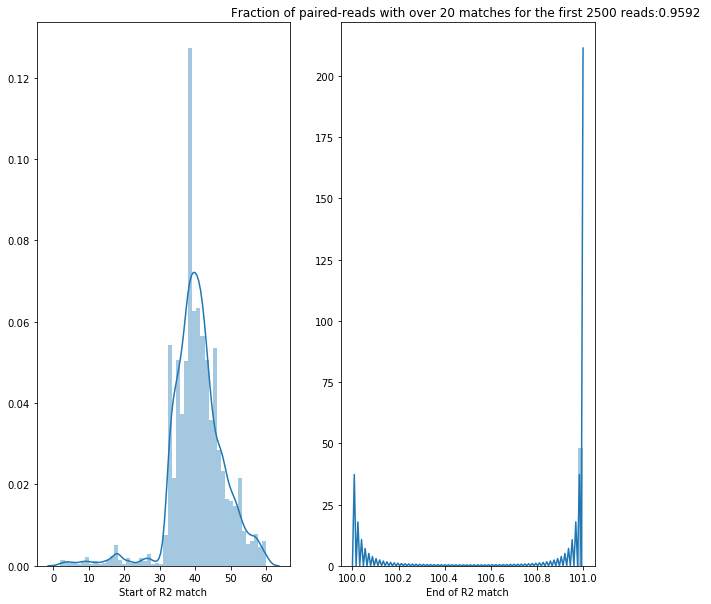

In [18]:
f, ax = plt.subplots(1,2,figsize=(10,10))
sns.distplot(small_frag_df["Start of R2 match"],ax=ax[0])
plt.title(f"Fraction of paired-reads with over 20 matches for the first 2500 reads:{small_frag_df.shape[0]/reads.shape[0]} ")
sns.distplot(small_frag_df["End of R2 match"],ax=ax[1])
plt.savefig(join(data_dir,"small_inserts.png"), bbox_inches='tight')

